# Selecting useful features

When looking at the second model's feature importances, we saw that the TF-IDF vectorization features were suspiciously absent from the most important features we displayed. To verify that a model can perform well without these features, let's omit them and train a third model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import format_raw_df

np.random.seed(35)

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

df = df.loc[df["is_question"]].copy()

In [2]:
from ml_editor.data_processing import get_split_by_author

df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

The function below add features. Feel free to check out the ml_editor source code to see more about what these functions are doing!

In [3]:
from ml_editor.model_v2 import add_char_count_features, get_word_stats, get_sentiment_score

df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/emmanuel.ameisen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 7971/7971 [00:20<00:00, 394.74it/s]


In [4]:
from ml_editor.model_v2 import POS_NAMES

feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# Model

Now that we've added our new features, let's train a new model. We'll use the same architecture as before, but with new features. You can visualize the new features below.

In [5]:
# We split again since we have now added all features. 
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [6]:
df[feature_arr].head()*100

,num_questions,num_periods,num_commas,num_exclam,num_quotes,num_colon,num_stops,num_semicolon,num_words,num_chars,...,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
Id,,,,,,,,,,,,,,,,,,,,,
1,56.818182,56.818182,28.409091,0.0,0.000000,0.0,1022.727273,0.0,2073.863636,35200,...,3.693182,0.0,1.136364,1.420455,0.000000,1.988636,0.0,0.000000,5.113636,0.0
2,90.634441,30.211480,60.422961,0.0,60.422961,0.0,1087.613293,0.0,2024.169184,33100,...,4.229607,0.0,0.000000,1.510574,0.000000,2.416918,0.0,0.000000,2.719033,0.0
3,175.438596,87.719298,87.719298,0.0,0.000000,0.0,1491.228070,0.0,2719.298246,11400,...,4.385965,0.0,0.000000,4.385965,0.000000,3.508772,0.0,0.000000,7.894737,0.0
5,70.257611,46.838407,117.096019,0.0,0.000000,0.0,843.091335,0.0,2154.566745,42700,...,3.512881,0.0,1.170960,0.702576,0.000000,2.810304,0.0,0.234192,4.215457,0.0
7,135.135135,67.567568,67.567568,0.0,0.000000,0.0,945.945946,0.0,2027.027027,14800,...,2.702703,0.0,0.000000,2.702703,1.351351,2.702703,0.0,0.000000,3.378378,0.0


In [7]:
def get_feature_vector_and_label(df, feature_names):
    """
    Generate input and output vectors using the vectors feature and
     the given feature names
    :param df: input DataFrame
    :param feature_names: names of feature columns (other than vectors)
    :return: feature array and label array
    """
    features = df[feature_names].astype(float)
    labels = df["Score"] > df["Score"].median()
    return features, labels


X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [8]:
y_train.value_counts()

False    3483
True     2959
Name: Score, dtype: int64

In [9]:
X_test.shape

(1529, 30)

We train a model using `sklearn`, and measure its performance using the methods we've covered below.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1



# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Training accuracy = 0.577, precision = 0.551, recall = 0.429, f1 = 0.482


In [12]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Validation accuracy = 0.584, precision = 0.597, recall = 0.461, f1 = 0.520


Let's save our new model and vectorizer to disk so we can use it later.

In [13]:
from sklearn.externals import joblib

model_path = Path("../models/model_3.pkl")
joblib.dump(clf, model_path) 

['../models/model_3.pkl']

## Validating that features are useful

Let's look at feature importances to validate that our new features are being used by the new model.

In [14]:
from ml_editor.model_evaluation import get_feature_importance

all_feature_names = np.array(feature_arr)

In [15]:
k = 20
print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

Top 20 importances:

num_chars: 0.053
num_questions: 0.051
num_periods: 0.051
ADV: 0.049
ADJ: 0.049
num_diff_words: 0.048
DET: 0.048
NOUN: 0.045
VERB: 0.045
PUNCT: 0.045
ADP: 0.044
num_commas: 0.044
num_stops: 0.043
polarity: 0.043
PRON: 0.042
num_words: 0.042
avg_word_len: 0.042
PART: 0.042
PROPN: 0.032
NUM: 0.027

Bottom 20 importances:

ADP: 0.044
num_commas: 0.044
num_stops: 0.043
polarity: 0.043
PRON: 0.042
num_words: 0.042
avg_word_len: 0.042
PART: 0.042
PROPN: 0.032
NUM: 0.027
num_colon: 0.022
num_quotes: 0.02
AUX: 0.016
SYM: 0.015
INTJ: 0.014
X: 0.011
num_semicolon: 0.0076
num_exclam: 0.0072
CONJ: 0
SCONJ: 0


## Comparing predictions to data

This section uses the evaluation methods described in the Comparing Data To Predictions notebook on this third model.

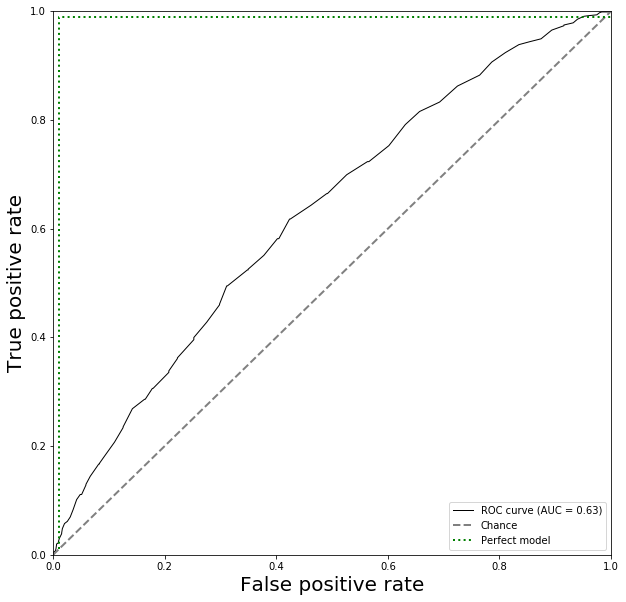

In [16]:
from ml_editor.model_evaluation import get_roc_plot

get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

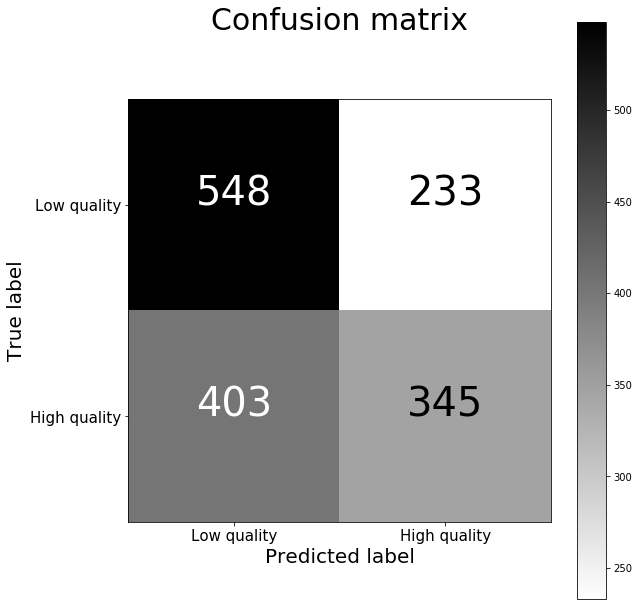

In [17]:
from ml_editor.model_evaluation import get_confusion_matrix_plot

%load_ext autoreload
%autoreload 2


get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No handles with labels found to put in legend.


	Brier: 0.238


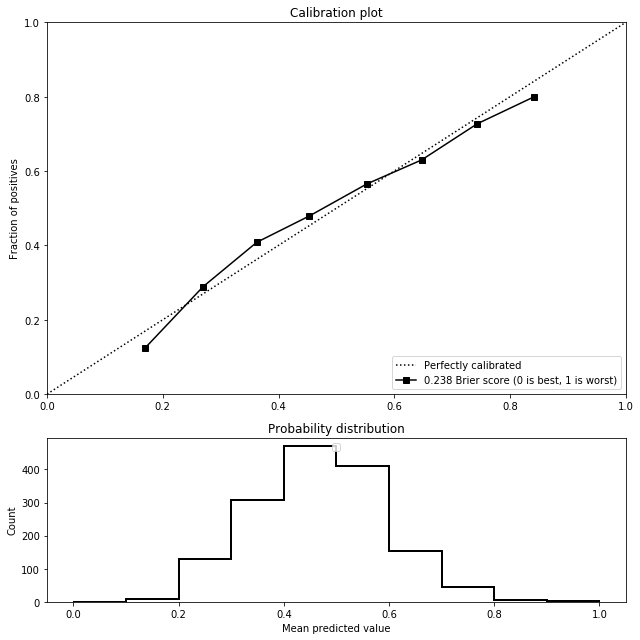

In [18]:
from ml_editor.model_evaluation import get_calibration_plot

get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

This third model only uses features that can be easily interpreted, and is better calibrated than previous models. This makes it a very good candidate for our application (feel free to look at `Comparing Models` for a more detailed comparison).

## Running Inference

Just like for our first two models, we define an inference function that takes in an arbitrary question and outputs an estimated probability of it receiving a high score according to our model.

In [19]:
from ml_editor.model_v2 import get_question_score_from_input
    
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████| 1/1 [00:00<00:00, 596.71it/s]

0.36 probability of the question receiving a high score according to our model
